In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from collections import namedtuple
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import fbeta_score
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_next_year(year, region, df):
    if year+1 not in set(df[YEAR_COL]):
        return float('nan')
    return df.loc[(df[YEAR_COL]==year+1) & (df[REGION_COL]==region), TARGET].values[0]

In [3]:
df = pd.read_csv(r"C:\Users\olive\Documents\GitHub\MontrealFireSafetyProject\data\all_data_clean.csv", index_col=0)

TARGET = 'incident'
YEAR_COL = 'Year'
REGION_COL = 'Poly_Key'

df[REGION_COL] = df[REGION_COL].astype('str')
df['Next Year'] = df['Year'].apply(lambda x: int(x+1))

left = df.copy()
right = df.copy()

left['idx'] = left.apply(lambda row: "{}_{}".format(row['Poly_Key'], row['Year']), axis=1)
right['idx'] = right.apply(lambda row: "{}_{}".format(row['Poly_Key'], row['Next Year']), axis=1)

left = left.set_index(['idx'], drop=True)
right = right.set_index(['idx'], drop=True)

tot = left.join(right, lsuffix='_nextyear', rsuffix='_thisyear', how='inner')
tot = tot[['Poly_Key_nextyear', 'Building_fire_nextyear', 'incident_nextyear', 
           *[x for x in tot.columns if x[-9:]=='_thisyear']]]

tot = tot.drop(['Next Year_thisyear'], axis=1)
tot = tot.set_index(['Poly_Key_thisyear', 'Year_thisyear'], drop=True)

df = tot.reset_index(drop=True).copy()
X, y = df.drop([TARGET + '_nextyear'], axis=1), df[TARGET + '_nextyear']
y = y.apply(lambda x: 1 if x > 0 else 0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
X_train.head()

,Poly_Key_nextyear,Building_fire_nextyear,CFSAUID_thisyear,Building_fire_thisyear,incident_thisyear,Desc_gr_clean_Alarmes-incendies_thisyear,Desc_gr_clean_Autres incendies_thisyear,Desc_gr_clean_Fausses alertes/annulations_thisyear,Desc_gr_clean_Nouveau_thisyear,Desc_gr_clean_Premier répondant_thisyear,...,Num_units_avg_thisyear,Num_units_median_thisyear,Num_units_max_thisyear,Construction_Year_min_thisyear,Construction_Year_max_thisyear,Construction_Year_avg_thisyear,Construction_Year_median_thisyear,Building_area_min_thisyear,Building_area_max_thisyear,Building_area_avg_thisyear
244881,POLYGON ((-73.62656966437061 45.46629447100914...,0.0,H4B,0.0,23.0,3,0,0,0,11.0,...,9.416667,1.0,181.0,1910.0,1998.0,1940.541667,1927.5,198.0,2741.0,479.041667
183990,POLYGON ((-73.57983975333164 45.47149562109404...,0.0,H4E,0.0,10.0,1,1,0,0,4.0,...,0.000000,0.0,0.0,1908.0,2014.0,1960.222222,1959.0,2727.0,334978.0,43175.700000
65361,POLYGON ((-73.83743610069625 45.50627327727052...,0.0,H8Z,0.0,1.0,0,0,0,0,0.0,...,1.000000,1.0,1.0,1961.0,1968.0,1962.533333,1961.0,477.0,656.0,569.800000
91098,POLYGON ((-73.90670752577309 45.46087741240239...,0.0,H9K,0.0,2.0,0,0,0,0,2.0,...,0.947368,1.0,1.0,1956.0,2015.0,2001.111111,2003.0,316.0,1705.0,954.578947
198394,"POLYGON ((-73.58290815319209 45.4827327256691,...",0.0,H4C,0.0,1.0,0,0,0,0,0.0,...,1.730769,1.0,3.0,1900.0,2008.0,1910.680000,1900.0,55.0,6253.0,594.115385


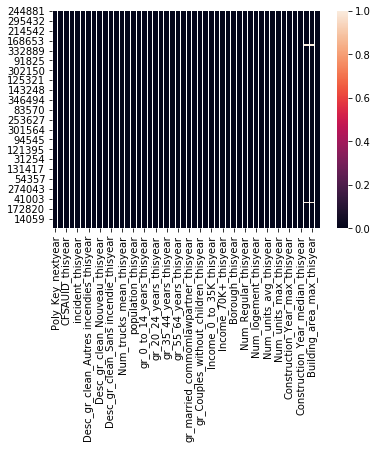

In [6]:
sns.heatmap(X_train.isna())

In [7]:
numerical_features = ['Building_fire_thisyear', 'incident_thisyear',
                      'Desc_gr_clean_Alarmes-incendies_thisyear',
                      'Desc_gr_clean_Autres incendies_thisyear',
                      'Desc_gr_clean_Fausses alertes/annulations_thisyear',
                      'Desc_gr_clean_Nouveau_thisyear',
                      'Desc_gr_clean_Premier répondant_thisyear',
                      'Desc_gr_clean_Sans incendie_thisyear', 'Num_trucks_total_thisyear',
                      'Num_trucks_mean_thisyear', 'Num_trucks_median_thisyear',
                      'population_thisyear', 'total_dwellings_thisyear',
                      'gr_0_to_14_years_thisyear', 'gr_15_19_years_thisyear',
                      'gr_20_24_years_thisyear', 'gr_25_34_years_thisyear',
                      'gr_35_44_years_thisyear', 'gr_45_54_years_thisyear',
                      'gr_55_64_years_thisyear', 'gr_65plus_years_thisyear',
                      'gr_married_commomlawpartner_thisyear',
                      'gr_Couples_with_children_thisyear',
                      'gr_Couples_without_children_thisyear', 'income_per_capita_thisyear',
                      'Income_0_to_35K_thisyear', 'Income_35K_to_70K_thisyear',
                      'Income_70K+_thisyear', 'population tax payers_thisyear',
                      'Num_buildings_thisyear', 'Num_Regular_thisyear',
                      'Num_Condo_thisyear', 'Num_logement_thisyear', 'Num_units_sum_thisyear',
                      'Num_units_avg_thisyear', 'Num_units_median_thisyear',
                      'Num_units_max_thisyear', 'Construction_Year_min_thisyear',
                      'Construction_Year_max_thisyear', 'Construction_Year_avg_thisyear',
                      'Construction_Year_median_thisyear', 'Building_area_min_thisyear',
                      'Building_area_max_thisyear', 'Building_area_avg_thisyear']

categorical_features = ['Borough_thisyear']

In [8]:
categorical_pipeline = Pipeline(steps=[('one_hot_encoder', OneHotEncoder(sparse=False, 
                                                                         drop='first',
                                                                         handle_unknown='error'))])

In [9]:
numerical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                     ('min_max_scalar', MinMaxScaler())])

In [10]:
prep_pipeline = ColumnTransformer([
    ("cat", categorical_pipeline, categorical_features),
    ("num", numerical_pipeline, numerical_features)
])

In [11]:
full_pipeline = Pipeline(steps=[('prep', prep_pipeline),
                                #('feature_engineering', SelectFromModel(estimator=DecisionTreeClassifier(), threshold='0.5*mean')),
                                ('estimator', LogisticRegression())])

In [12]:
full_pipeline.fit(X_train, y_train)

C:\Users\olive\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('one_hot_encoder',
                                                                   OneHotEncoder(categorical_features=None,
                                                                                 categories=None,
                                                                                 drop='first',
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='error',
                                    

In [13]:
y_pred = full_pipeline.predict(X_test)

In [14]:
f1_score(y_test, y_pred)

0.8400975983430979

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
len(y_test[y_test==1])/len(y_test)

0.658613047431429

In [17]:
accuracy_score(y_test, y_pred)

0.7864828004243067

### Baseline: Predict next year there will be an incident if there was this year

In [18]:
y_b1 = X_test[TARGET + '_thisyear']
y_b1 = y_b1.apply(lambda x: 1 if x>0 else 0)

In [19]:
f1_score(y_test, y_b1)

0.8358873210944218

In [20]:
accuracy_score(y_test, y_b1)

0.7848632368540688

In [21]:
feature_importances = dict(zip(numerical_features, full_pipeline.steps[-1][1].coef_[0, :]))

In [22]:
from operator import itemgetter
from collections import OrderedDict

N = 10
pos_top = dict(sorted(feature_importances.items(), key = itemgetter(1), reverse = True)[:N])
neg_top = dict(sorted(feature_importances.items(), key = itemgetter(1), reverse = True)[-5:])
top_abs = {**pos_top, **neg_top}
top_abs = OrderedDict(sorted(top_abs.items(), key=lambda t: abs(t[1])))

In [23]:
top_n = dict()
for key, val in top_abs.items():
    old_key = key
    new_key = key.replace('_thisyear', '')
    top_n[new_key] = top_abs[old_key]

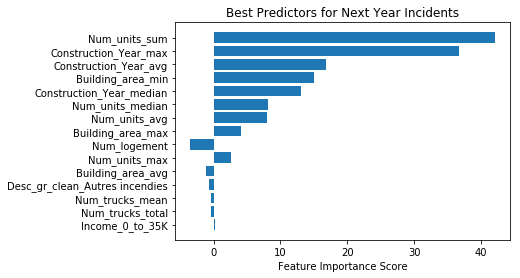

In [24]:
plt.barh(range(len(top_n)), list(top_n.values()), align='center')
plt.yticks(range(len(top_n)), list(top_n.keys()), rotation='horizontal')
plt.title("Best Predictors for Next Year Incidents");
plt.xlabel("Feature Importance Score");

In [25]:
Pipeline(full_pipeline.steps[:-1]).transform(X_train).shape

(246362, 76)

In [32]:
thisyear = pd.read_csv(r"C:\Users\olive\Documents\GitHub\MontrealFireSafetyProject\data\all_data_clean.csv", index_col=0)

In [35]:
thisyear = thisyear.loc[thisyear['Year']==2019]

In [38]:
thisyear = thisyear.set_index(['Poly_Key'], drop=True)

In [40]:
thisyear.columns = [x + '_thisyear' for x in thisyear.columns]

In [53]:
forecast_inp = thisyear[[*numerical_features, *categorical_features]].copy()
forecast_inp['Building_fire_nextyear'] = float('nan')
forecast_inp['CFSAUID_thisyear'] = float('nan')
forecast_inp['Poly_Key_nextyear'] = float('nan')

In [58]:
forecast_inp['2020_incidents_forecast'] = full_pipeline.predict_proba(forecast_inp[X_train.columns])[:, 1]

In [61]:
forecast_inp.to_csv('../data/2020_forecast.csv')